# Цель:
# Исследовать, как различные техники аугментации данных влияют на качество работы сверточных нейронных сетей и определить оптимальное соотношение аугментированных данных к исходным.*

In [ ]:
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.optim.adam as adam
import torch

import numpy as np 
import pandas as pd

from torch.utils.data import ConcatDataset, Subset
import albumentations as A
from albumentations.pytorch import ToTensorV2
from PIL import Image
#from tqdm.auto import tqdm
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import transforms
import torchvision.transforms.v2 as transforms_v2



In [ ]:
from tqdm import tqdm
from functools import partial
import sys
tqdm = partial(tqdm, file=sys.stdout)

CNN: 
Сверточные блоки: 3 последовательных слоя (Conv2d + BatchNorm + Activation + MaxPool)  
Адаптивный пулинг приводит feature map к фиксированному размеру 8x8.  
Классификатор из двух линейных слоев, который преобразует признаки в 200-мерный вектор логитов (для 200 классов).

In [ ]:
class myCNN(nn.Module):
    def __init__(self):
        super().__init__()
        #вход 3*64*64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.GELU(),
            nn.MaxPool2d(2)
        )
        # получили 64*32*32
        self.conv2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        #получили 128*16*16
        self.conv3 = nn.Sequential(
            nn.Conv2d(128, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.adapt_pool = nn.AdaptiveAvgPool2d((8, 8))
        #получили 64 * 8 * 8
        self.fc1 = nn.Sequential(
            nn.Linear(64*8*8, 512),
            nn.ReLU(),
            nn.Dropout(0.2),
        )
        self.fc2 = nn.Linear(512, 200)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.adapt_pool(x)
        x = x.view(x.size(0), - 1)
        x = self.fc1(x)
        return self.fc2(x)

In [ ]:
#бейзлайн для проверки. задаем преобразования изображений
from torchvision import datasets, transforms


train_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


train_dataset = datasets.ImageFolder\
(root='/kaggle/input/intel-image-classification/seg_train/seg_train', transform=train_transforms)
test_dataset = datasets.ImageFolder(\
    root='/kaggle/input/intel-image-classification/seg_test/seg_test', transform=test_transforms)



train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


print(train_dataset.classes)  # ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
print(len(train_dataset))


['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']
14034


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
# передача данных в модель, обучение модели
def solve_train(train_loader):
    model = myCNN().to(device)
    loss_func = nn.CrossEntropyLoss()#weight=class_weights)
    optimizator = adam.Adam(model.parameters(), lr=0.001)

    train_losses = []
    train_accs = []
    
    epoch = 5
    for i in range(epoch):
        model.train()

        epoch_loss = 0.0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f"Эпоха {i+1}/{epoch}")
        for images, labels in pbar:
            images = images.to(device)
            labels = labels.to(device)
            
            optimizator.zero_grad()
            outputs = model(images)
            loss = loss_func(outputs, labels)
            loss.backward()
            optimizator.step()

            epoch_loss += loss.item() * images.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            pbar.set_postfix({"loss": loss.item()})
            
        avg_loss = epoch_loss / total
        accuracy = correct / total
        train_losses.append(avg_loss)
        train_accs.append(accuracy)
            
            
    return model, train_losses, train_accs
            

In [ ]:
#валидация модели и расчет метрик
def eval_and_metrics(model):
    y_true, y_pred = [], []
    model.eval()

    test_loss = 0
    correct = 0
    total = 0
    loss_func = nn.CrossEntropyLoss()
    
    with torch.no_grad():
        for images, labels in tqdm(test_loader, desc=f'Валидация '):
            images = images.to(device)
            labels = labels.to(device)
    
            outputs = model(images)
            loss = loss_func(outputs, labels)
            test_loss += loss.item() * images.size(0)
            
            pred = torch.argmax(outputs, dim=1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(pred.cpu().numpy())

            total += labels.size(0)
            correct += (pred == labels).sum().item()

    avg_test_loss = test_loss / total
    
    ac = accuracy_score(y_true, y_pred)
    rc = recall_score(y_true, y_pred, average='macro')
    pr = precision_score(y_true, y_pred, average='macro')
    f1 = f1_score(y_true, y_pred, average='macro')
    
    print(f'{ac}\n{rc}\n{pr}\n{f1}')
    return model, ac, rc, pr, f1, y_true, y_pred, avg_test_loss

        
    

In [ ]:
solved_model, _, _ = solve_train(train_loader)
_, ac, pr, rc, f1, _, _, _ = eval_and_metrics(solved_model)

In [ ]:
#смешиваем аугментированные данные и исходные
def mixed_datasets(orig, augment, ratio):
    size = len(orig)
    aug_size = int(size*ratio)
    orig_size = size - aug_size

    orig_indices = torch.randperm(len(orig))[:orig_size].tolist()
    aug_indices = torch.randperm(len(augment))[:aug_size].tolist()

    
    orig_part = Subset(orig, orig_indices)
    aug_part = Subset(augment, aug_indices)
    return ConcatDataset([orig_part, aug_part])

In [ ]:
#считаем нашу модельку для разных соотношений аугментированных данных и исходным
def different_ratio(train_dataset_orig, train_dataset_aug):
    ratio_massiv = [0, 0.25, 0.5, 0.75, 1]
    all_train_losses = []  
    all_train_accs = []    
    all_metrics = []    
    all_models = []
    
    
    for i, ratio in enumerate(ratio_massiv):
        print(f'{ratio}')
        original_dataset = train_dataset_orig
        augment_dataset = train_dataset_aug
        final_dataset = mixed_datasets(original_dataset,\
                                augment_dataset, ratio)
        train_loader = DataLoader(final_dataset, batch_size=32, shuffle=True)
    
        
        model_solve, train_losses, train_accs =  solve_train(train_loader)
        all_train_losses.append(train_losses)
        all_train_accs.append(train_accs)
        all_models.append(model_solve)
        
        model, ac, rc, pr, f1, \
            y_true, y_pred, avg_test_loss = eval_and_metrics(model_solve)

        all_metrics.append({
            'ratio': ratio,
            'accuracy': ac,
            'recall': rc, 
            'precision': pr,
            'f1': f1,
            'test_loss': avg_test_loss
        })
        

    return all_train_losses, all_train_accs, all_metrics, all_models
    
        
        


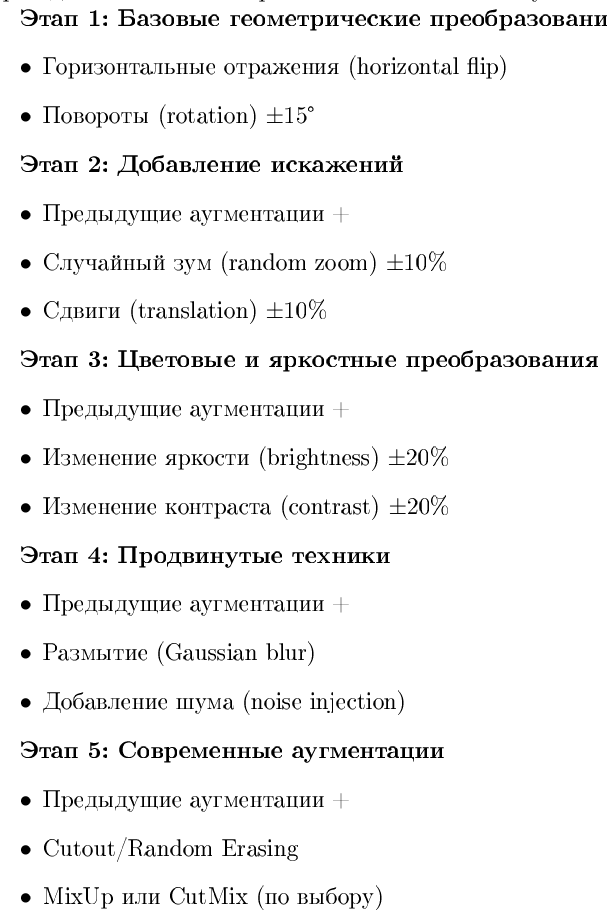

In [ ]:
#определяем разные способы аугментации к данным
base = [transforms.Resize((128, 128)),transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]

stage1 = [transforms.RandomHorizontalFlip(p=0.4),transforms.RandomRotation(degrees=15)]

stage2 = [transforms.RandomAffine(degrees=15,translate=(0.1, 0.1),scale=(0.9, 1.1))] #сдвиг, масштаб

stage3 = [transforms.ColorJitter(brightness=0.2, contrast=0.2)] # яркость, контраст
stage5 = [transforms_v2.RandomErasing(p=0.5, scale=(0.02, 0.1), ratio=(0.3, 3.3))]

# Кастомка для шума
class AddGaussianNoise:
    def __init__(self, mean=0., std=0.1, p=0.5):
        self.mean = mean
        self.std = std
        self.p = p
        
    def __call__(self, tensor):
        if torch.rand(1) < self.p:
            return tensor + torch.randn(tensor.size()) * self.std + self.mean
        return tensor

stage4 = [
    transforms.GaussianBlur(kernel_size=3),
    AddGaussianNoise(std=0.05, p=0.2)
]
torch_base_transform = transforms.Compose(base)
base_train_dataset = datasets.ImageFolder(
    root='/kaggle/input/intel-image-classification/seg_train/seg_train',
    transform=torch_base_transform)

torch_transforms1 = transforms.Compose(base + stage1)
torch_transforms2 = transforms.Compose(base + stage1 + stage2)
torch_transforms3 = transforms.Compose(base + stage1 + stage2 + stage3)
torch_transforms4 = transforms.Compose(base + stage1 + stage2 + stage3 + stage4)
torch_transforms5 = transforms.Compose(base + stage1 + stage2 + stage3 + stage4 + stage5)

all_torch_transforms = [
    torch_transforms1,
    torch_transforms2, 
    torch_transforms3,
    torch_transforms4,
    torch_transforms5
]

Этап аугментации____1
0
Валидация : 100%|██████████| 94/94 [00:10<00:00,  8.96it/s]
0.838
0.8414603462627807
0.8410640863429607
0.8393653184980551
0.25
Валидация : 100%|██████████| 94/94 [00:06<00:00, 14.11it/s]
0.8453333333333334
0.8479116109856139
0.8473836923743724
0.8462952399037192
0.5
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.96it/s]
0.8303333333333334
0.8332369203160342
0.8385653375413731
0.8326230886683476
0.75
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.42it/s]
0.834
0.834934640136621
0.8384705242569397
0.8353511956698544
1
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.08it/s]
0.8373333333333334
0.8420443278013835
0.8452868274598245
0.8378967437556963
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.51it/s]
0.8453333333333334
0.8479116109856139
0.8473836923743724
0.8462952399037192
НОВАЯ ГЛОБАЛЬНО ЛУЧШАЯ МОДЕЛЬ. Эпоха=1, F1=0.8463


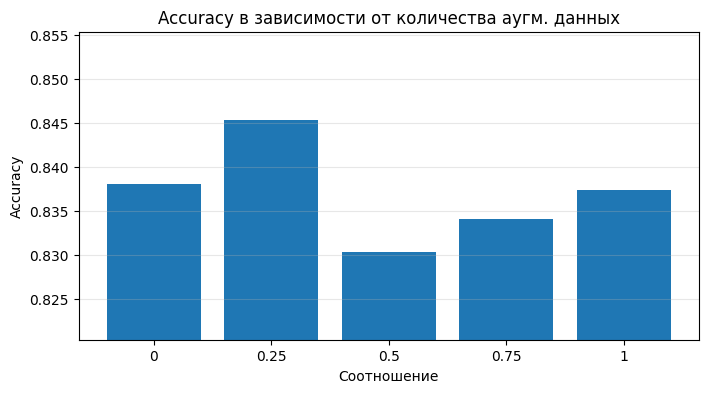

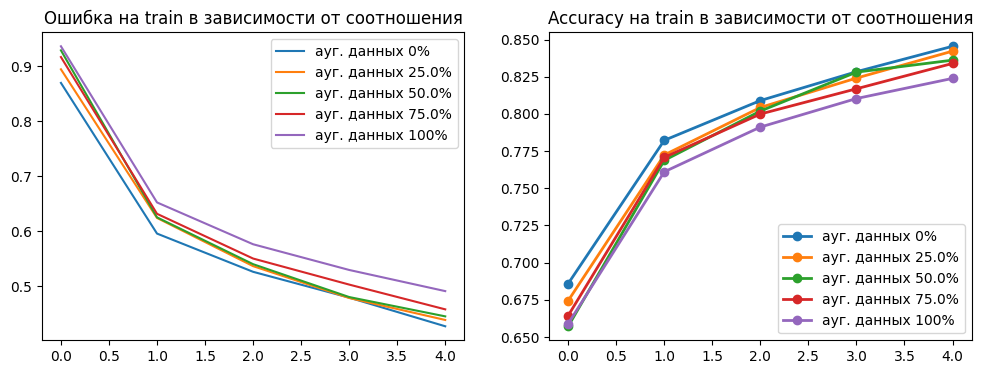

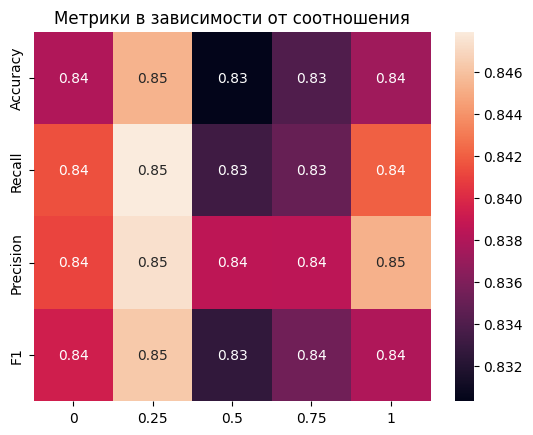

Этап аугментации____2
0
Валидация : 100%|██████████| 94/94 [00:06<00:00, 14.26it/s]
0.836
0.8345383198112963
0.8422611003768009
0.8351530674069118
0.25
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.91it/s]
0.8226666666666667
0.8254163244778928
0.8286843722378728
0.8245274550316241
0.5
Валидация : 100%|██████████| 94/94 [00:06<00:00, 14.21it/s]
0.8366666666666667
0.8385967496657457
0.8389910767830168
0.8378561402312127
0.75
Валидация : 100%|██████████| 94/94 [00:07<00:00, 12.99it/s]
0.8223333333333334
0.8218997475543919
0.828396175711421
0.8232191211035245
1
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.62it/s]
0.8193333333333334
0.8210276568021605
0.8233783926845736
0.8198767636217466
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.46it/s]
0.8366666666666667
0.8385967496657457
0.8389910767830168
0.8378561402312127


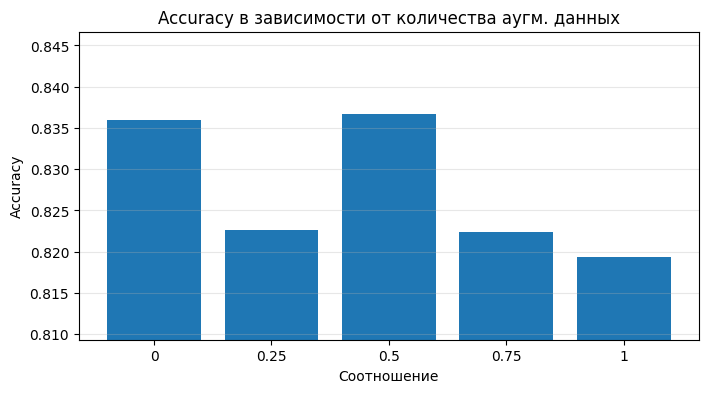

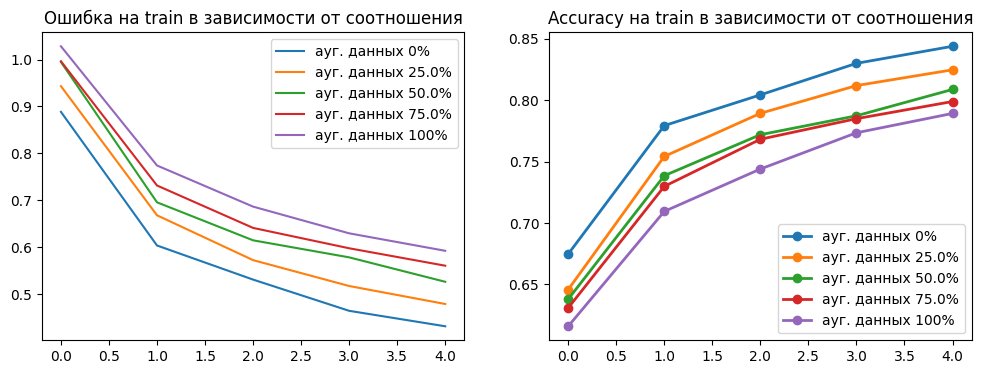

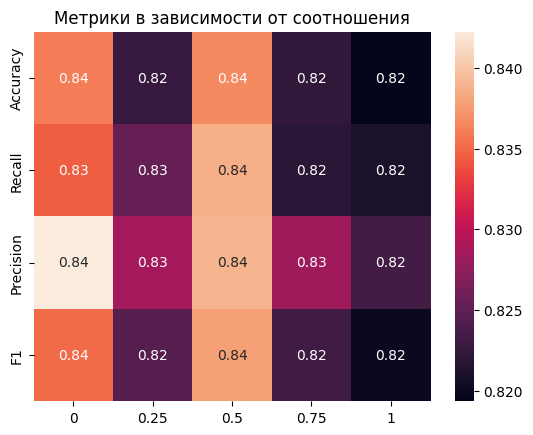

Этап аугментации____3
0
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.87it/s]
0.83
0.8342911527616925
0.8390312747767185
0.8307937933459294
0.25
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.77it/s]
0.8246666666666667
0.8253027351718831
0.8345955505255557
0.8267957671484254
0.5
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.99it/s]
0.804
0.8053199054942928
0.8163695233972859
0.8046356274484442
0.75
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.74it/s]
0.7733333333333333
0.7687679584917698
0.799920369372201
0.7679258324020554
1
Валидация : 100%|██████████| 94/94 [00:06<00:00, 14.21it/s]
0.6976666666666667
0.7052674784618089
0.729312760034036
0.7022978356597621
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.82it/s]
0.83
0.8342911527616925
0.8390312747767185
0.8307937933459294


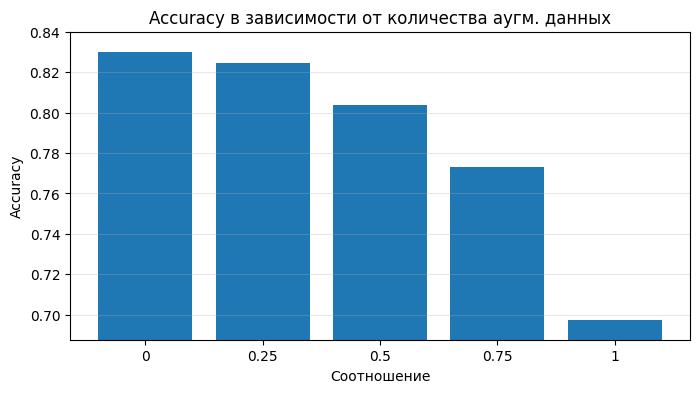

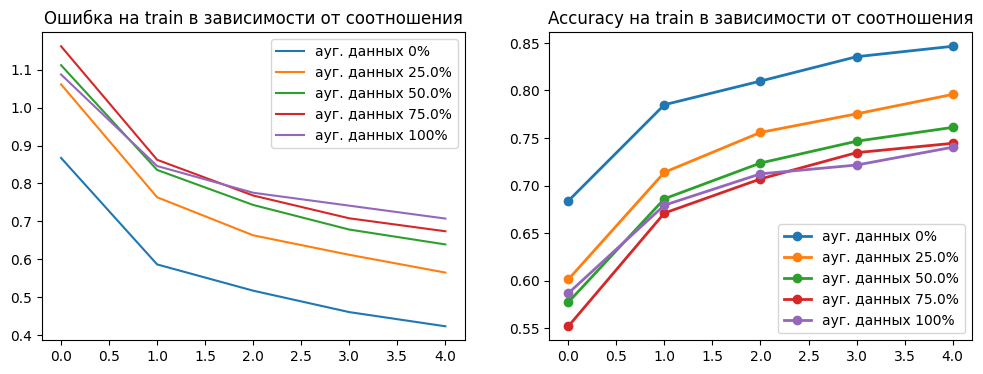

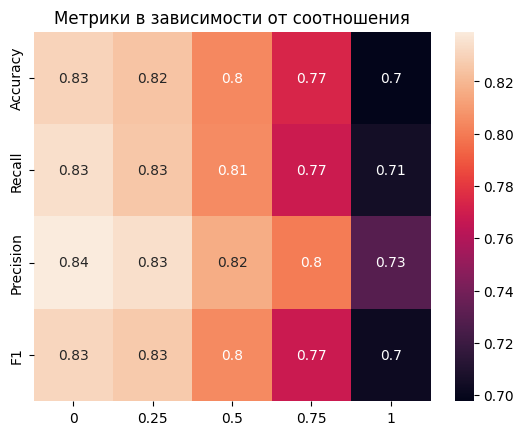

Этап аугментации____4
0
Валидация : 100%|██████████| 94/94 [00:06<00:00, 14.00it/s]
0.8496666666666667
0.8482787043722416
0.8554207647929664
0.848871603700315
0.25
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.43it/s]
0.8316666666666667
0.8331686516550517
0.8368985091958723
0.832935253124839
0.5
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.74it/s]
0.807
0.8049088758549798
0.8128093355867371
0.8048738489630997
0.75
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.78it/s]
0.785
0.7878204573402806
0.7999742865143182
0.7871101228219705
1
Валидация : 100%|██████████| 94/94 [00:08<00:00, 10.70it/s]
0.49466666666666664
0.4986598964517614
0.6657322310568065
0.4470024224556288
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.49it/s]
0.8496666666666667
0.8482787043722416
0.8554207647929664
0.848871603700315
НОВАЯ ГЛОБАЛЬНО ЛУЧШАЯ МОДЕЛЬ. Эпоха=4, F1=0.8489


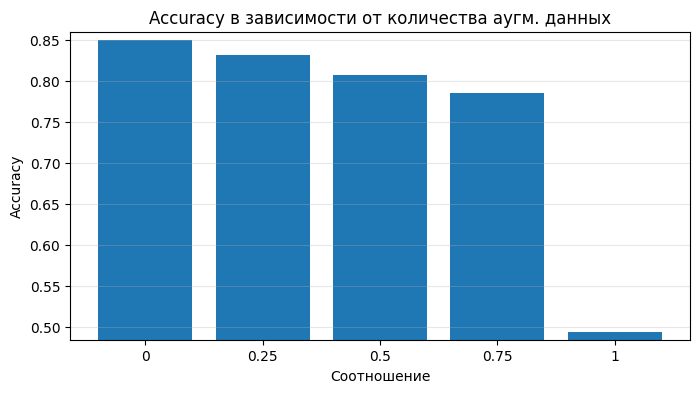

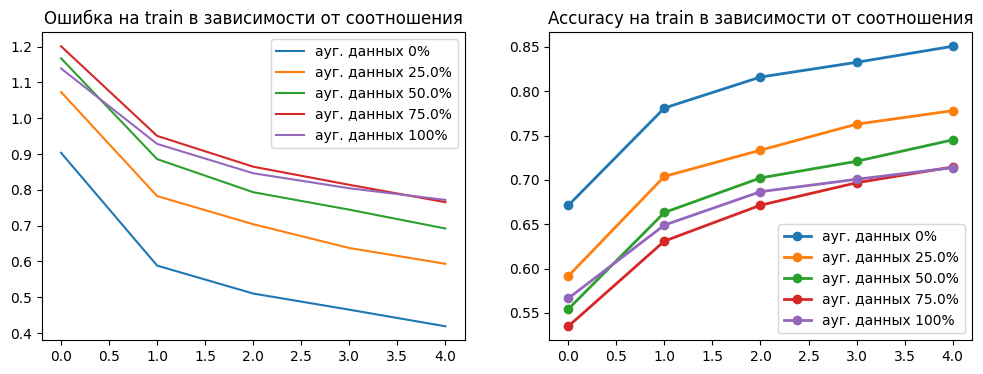

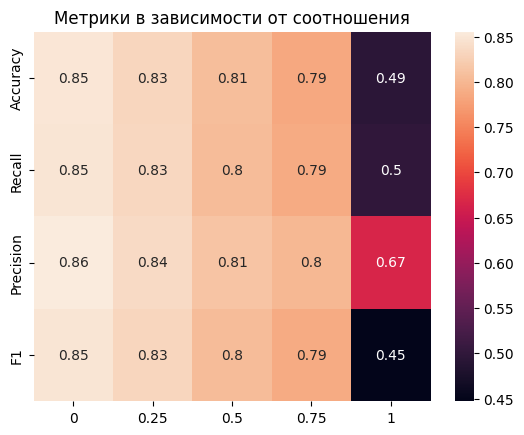

Этап аугментации____5
0
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.48it/s]
0.8306666666666667
0.8345769625817469
0.8369209293618408
0.8309629476146974
0.25
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.37it/s]
0.8173333333333334
0.8153664280396203
0.8253995127203101
0.8163092830065767
0.5
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.58it/s]
0.8056666666666666
0.8069459202152033
0.8057270244974676
0.8052126879486997
0.75
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.42it/s]
0.78
0.7793575362699864
0.7885936062432631
0.7807993915595053
1
Валидация : 100%|██████████| 94/94 [00:07<00:00, 13.39it/s]
0.4676666666666667
0.47336363220770533
0.6700985156683203
0.41905363195454187
Валидация : 100%|██████████| 94/94 [00:06<00:00, 13.63it/s]
0.8306666666666667
0.8345769625817469
0.8369209293618408
0.8309629476146974


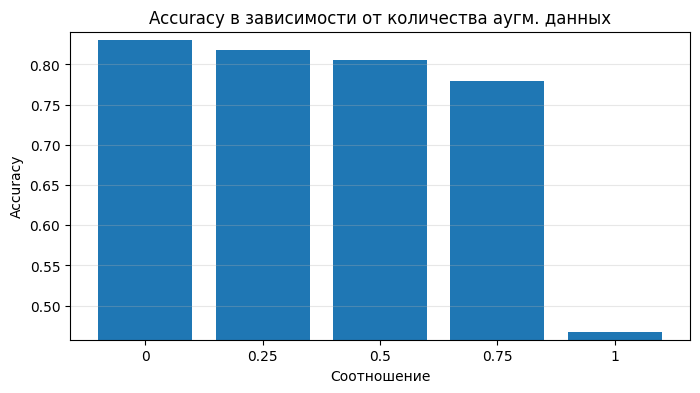

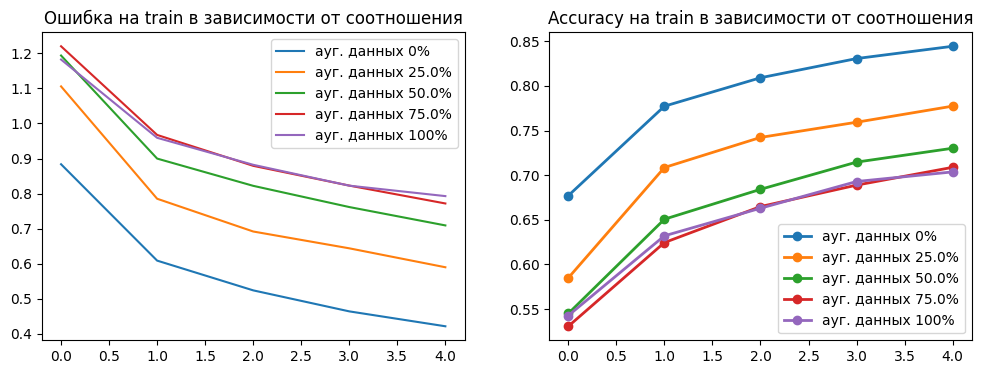

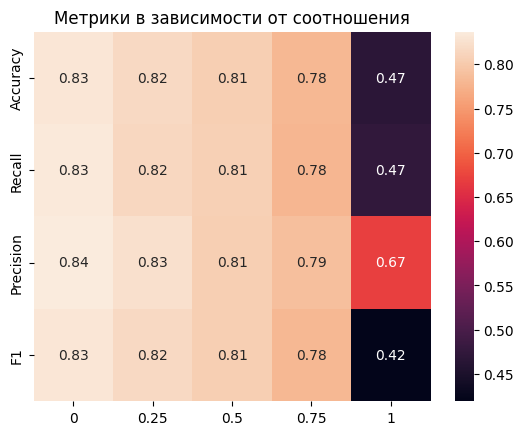

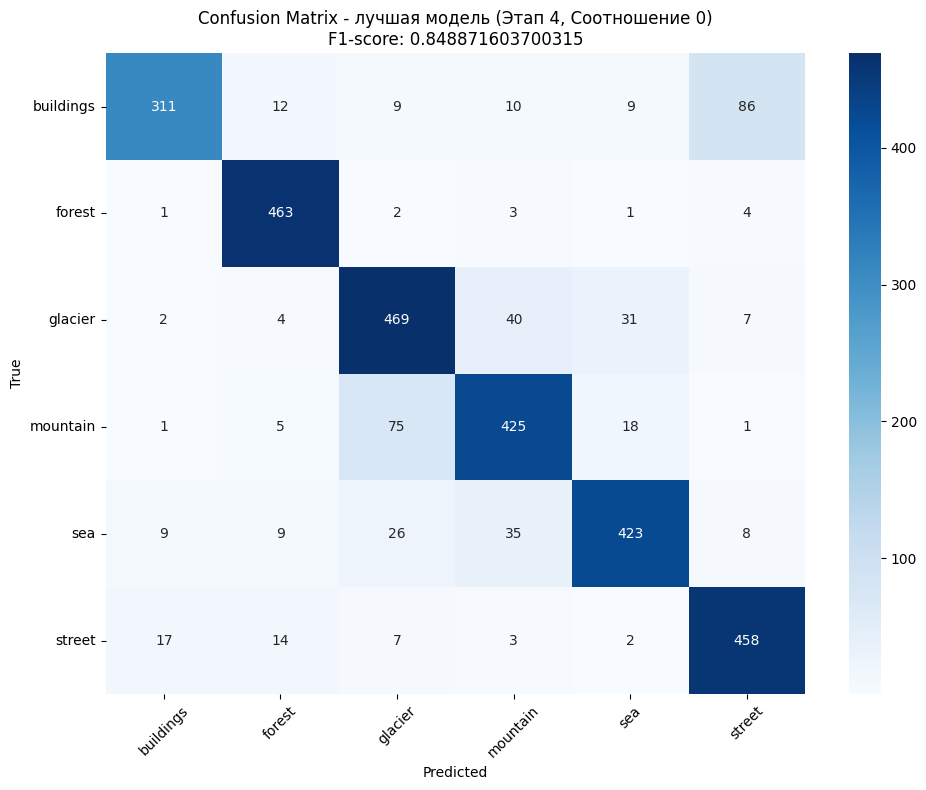

Classification Report:
              precision    recall  f1-score   support

   buildings       0.91      0.71      0.80       437
      forest       0.91      0.98      0.94       474
     glacier       0.80      0.85      0.82       553
    mountain       0.82      0.81      0.82       525
         sea       0.87      0.83      0.85       510
      street       0.81      0.91      0.86       501

    accuracy                           0.85      3000
   macro avg       0.86      0.85      0.85      3000
weighted avg       0.85      0.85      0.85      3000



In [ ]:
# проходим по всем способам аугментации данных и по всем соотношениям аугментированных данных к исходным
best_global_model = None
best_global_f1 = 0
best_global_stage = 0
best_global_ratio = 0
best_global_predictions = None

for i in range(len(all_torch_transforms)):
    print(f'Этап аугментации____{i+1}')
    train_transforms = all_torch_transforms[i]
    
    #train_dataset = datasets.ImageFolder(
        #root='/kaggle/input/intel-image-classification/seg_train/seg_train',
        #transform=train_transforms)
    #train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    aug_dataset = datasets.ImageFolder(\
        root='/kaggle/input/intel-image-classification/seg_train/seg_train',\
        transform=all_torch_transforms[i])

    all_train_losses, all_train_accs, \
        all_metrics, all_models = different_ratio(\
            base_train_dataset,aug_dataset )

    best_stage_idx = np.argmax([m['f1'] for m in all_metrics])
    best_stage_model = all_models[best_stage_idx]
    best_stage_ratio = all_metrics[best_stage_idx]['ratio']
    best_stage_f1 = all_metrics[best_stage_idx]['f1']


    _, ac, rc, pr, best_stage_f1, y_true, y_pred, avg_test_loss = eval_and_metrics(
        best_stage_model)
    
    if best_stage_f1 > best_global_f1:
        best_global_f1 = best_stage_f1
        best_global_model = best_stage_model
        best_global_stage = i + 1
        best_global_ratio = best_stage_ratio
        best_global_predictions = (y_true, y_pred)
        print(f'НОВАЯ ГЛОБАЛЬНО ЛУЧШАЯ МОДЕЛЬ. Эпоха={i+1}, F1={best_stage_f1:.4f}')

    
    # 1. Сравнение accuracy по соотношениям
    ratios = [m['ratio'] for m in all_metrics]
    accuracies = [m['accuracy'] for m in all_metrics]
    
    plt.figure(figsize=(8,4))
    plt.bar([str(r) for r in ratios], accuracies)
    plt.title('Accuracy в зависимости от количества аугм. данных')
    plt.xlabel('Соотношение')
    plt.ylabel('Accuracy')
    plt.ylim(min(accuracies) - 0.01, max(accuracies) + 0.01)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

    # 2 Learning curves для каждого соотношения
    '''
    print("Ошибка в train в зависимости от коэффициента:")
    for i, (ratio, losses) in enumerate(zip(ratios, all_train_losses)):
        print(f"{ratio}: {losses}")
    
    print("\n Точность в зависимости от соотношения:")
    for i, (ratio, accs) in enumerate(zip(ratios, all_train_accs)):
        print(f"{ratio}: {accs}")
    '''
    
    plt.figure(figsize=(12,4))
    plt.subplot(121)
    for i, ratio in enumerate(ratios):
        plt.plot(all_train_losses[i], label=f'ауг. данных {ratio*100}%')
    plt.title('Ошибка на train в зависимости от соотношения')
    plt.legend()
    
    plt.subplot(122)  
    for i, ratio in enumerate(ratios):
        plt.plot(all_train_accs[i], label=f'ауг. данных {ratio*100}%', marker='o', linewidth=2)
    plt.title('Accuracy на train в зависимости от соотношения')
    plt.legend()
    plt.show()
    
    # 3. Heatmap метрик
    metrics_matrix = np.array([
        [m['accuracy'] for m in all_metrics],
        [m['recall'] for m in all_metrics],
        [m['precision'] for m in all_metrics],
        [m['f1'] for m in all_metrics]
    ])
    
    sns.heatmap(metrics_matrix, annot=True, 
                xticklabels=ratios,
                yticklabels=['Accuracy', 'Recall', 'Precision', 'F1'])
    plt.title('Метрики в зависимости от соотношения')
    plt.show()


if best_global_predictions is not None:
    y_true, y_pred = best_global_predictions
    
    from sklearn.metrics import confusion_matrix
    import seaborn as sns
    
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10,8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=test_dataset.classes,
                yticklabels=test_dataset.classes)
    plt.title(f'Confusion Matrix - лучшая модель (Этап {best_global_stage}, Соотношение {best_global_ratio})\nF1-score: {best_global_f1}')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()
    
    print("Classification Report:")
    from sklearn.metrics import classification_report
    print(classification_report(y_true, y_pred, target_names=test_dataset.classes))
else:
    print("????????")

р р р 

Какие выводы можно сделать:
1) Лучший результат показала модель без аугментаций.
2) Loss в процессе обучения монотонно уменьшается, Accuracy растет -  причем и то и то не выходят на ассимптотику, поэтому стоит добавить еще эпох.
3) Наибольшее количество ошибок модель допускает в классах "building" и "street".  
4) На первых двух этапах аугментации можно получить прирост качества -  оптимальное соотношение - 0.25/0.75 (наибольший прирост на первом этапе) или 50/50. Последующие, более сложные аугментации (этапы 3-5) систематически снижают accuracy, поэтому их применение не рекомендуется.
